In [6]:
import math
import random

import pandas as pd
from pysorteddict import SortedDict


def setup(sorted_dict_len: int, seed: float = math.pi) -> SortedDict:
    random.seed(seed)
    d = SortedDict()
    for _ in range(sorted_dict_len):
        d[random.random()] = random.random()
    return d


sorted_dict_lens = [100, 1_000, 10_000, 100_000, 1_000_000, 10_000_000]

In [39]:
import matplotlib.pyplot as plt

plt.rc("figure", dpi=144)
plt.rc("font", family="Signika")

def plot(df: pd.DataFrame, title: str | None = None):
    df.plot(
        grid=True, logx=True, title=title, xlabel="Sorted Dictionary Length", xlim=(sorted_dict_lens[0], sorted_dict_lens[-1]), ylabel=""
    )

# `__contains__`

In [20]:
df = pd.DataFrame(index=sorted_dict_lens, columns=["0.00 in d", "0.33 in d", "0.66 in d", "1.00 in d"])
for i, sorted_dict_len in enumerate(sorted_dict_lens):
    print(f"{sorted_dict_len=}")
    d = setup(sorted_dict_len)
    for j, key in enumerate([0.00, 0.33, 0.66, 1.00]):
        bench = %timeit -o key in d
        df.iat[i, j] = bench.average
plot(df)

sorted_dict_len=100
37.5 ns ± 0.555 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)
44.4 ns ± 0.303 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)
41.2 ns ± 0.267 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)
32.8 ns ± 0.606 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)
sorted_dict_len=1000
48.4 ns ± 0.219 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)
60.8 ns ± 0.254 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)
54.5 ns ± 0.485 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)
60.6 ns ± 0.321 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)
sorted_dict_len=10000
64.1 ns ± 0.61 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)
68.5 ns ± 0.0873 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)
71.6 ns ± 0.137 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)
67.9 ns ± 0.974 ns per loop (mean ± std. dev. of 7 runs, 

AttributeError: 'float' object has no attribute 'average'

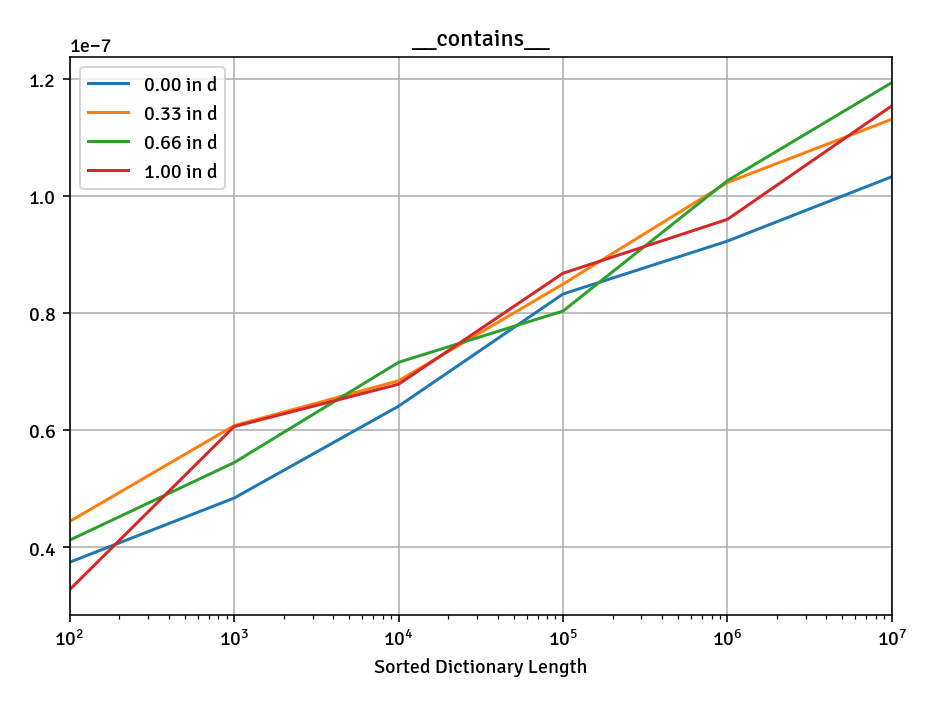

In [40]:
plot(df, "__contains__")

# `SortedDictKeys.__iter__`

In [ ]:
df = pd.DataFrame(index=sorted_dict_lens, columns=["for _ in d: pass"])
for i, sorted_dict_len in enumerate(sorted_dict_lens):
    print(f"{sorted_dict_len=}")
    d = setup(sorted_dict_len)
    bench = %timeit -o for _ in d: pass
    df.iloc[i] = bench.average
plot(df)

sorted_dict_len=100
767 ns ± 5.25 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
sorted_dict_len=1000
7.74 μs ± 84.9 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
sorted_dict_len=10000
118 μs ± 435 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
sorted_dict_len=100000
2.5 ms ± 405 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
sorted_dict_len=1000000
96.5 ms ± 941 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)
sorted_dict_len=10000000


In [43]:
df

,for _ in d: pass
100,NaN
1000,NaN
10000,NaN
100000,NaN
1000000,NaN
10000000,NaN


# `SortedDict.__setitem__`